## Training data cleaning

In [1]:
import pandas as pd
import numpy as np


#### CHANGE THESE PATHS TO CSV FILES ####
fake_filepath = r"C:\Users\vm658\Documents\SVSM\Research\Code\DataSet_Misinfo_FAKE.csv"
true_filepath = r"C:\Users\vm658\Documents\SVSM\Research\Code\DataSet_Misinfo_TRUE.csv"

In [2]:
fake_df = pd.read_csv(fake_filepath)
fake_df['label'] = 0
#remove first column
fake_df = fake_df.drop(fake_df.columns[0], axis=1)
#drop empty rows
fake_df = fake_df.dropna(how = 'any')
fake_df.drop_duplicates(subset = ['text'], inplace=True)
fake_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34078 entries, 0 to 43641
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    34078 non-null  object
 1   label   34078 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 798.7+ KB


In [3]:
true_df = pd.read_csv(true_filepath, encoding = 'latin-1')
true_df['label'] = 1
#remove first column
true_df = true_df.drop(true_df.columns[0], axis=1)
#drop empty rows
true_df = true_df.dropna(how = 'any')
true_df.drop_duplicates(subset = ['text'], inplace=True)
true_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34526 entries, 0 to 34974
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    34526 non-null  object
 1   label   34526 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 809.2+ KB


In [4]:
df=pd.concat([true_df,fake_df])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68604 entries, 0 to 43641
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    68604 non-null  object
 1   label   68604 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.6+ MB


In [5]:
import string

#add more punctuation
punctuations = string.punctuation + "’‘“”"
#remove punctuation
def remove_punctuation(text):
    no_punct = "".join([c for c in text if c not in punctuations])
    return no_punct

In [6]:
#remove punctuation
df['text'] = df['text'].apply(lambda x: remove_punctuation(x))
#make all text lowercase
df['text'] = df['text'].apply(lambda x: x.lower())

In [7]:
#splitting data for training and testing
import sklearn
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(df['text'],df['label'],test_size=0.2, random_state = 1)


## Test Data Cleaning

In [8]:
#### CHANGE THE PATH TO THE CSV FILE ####
test_df = pd.read_csv(r"C:\Users\vm658\Documents\SVSM\Research\Code\fake_or_real_news.csv")

#relabel fake and true data as 0 and 1
test_df['label'] = test_df.label.map({'FAKE': 0, 'REAL': 1})

test_df = test_df.drop(['Unnamed: 0'], axis=1)
test_df = test_df.dropna(how = 'any')
test_df.drop_duplicates(subset = ['title'], inplace=True)

#remove punctuation
test_df['title'] = test_df['title'].apply(lambda x: remove_punctuation(x))
#make all text lowercase
test_df['title'] = test_df['title'].apply(lambda x: x.lower())


#remove punctuation
test_df['text'] = test_df['text'].apply(lambda x: remove_punctuation(x))
#make all text lowercase
test_df['text'] = test_df['text'].apply(lambda x: x.lower())

In [9]:
#plot how many fake and true news articles there are
import matplotlib.pyplot as plt
#test_df.label.value_counts().plot(kind='pie', autopct='%1.0f%%')

In [10]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
import pickle

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['said', "'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'])
stop_words.extend(['is', 'it', 'to', 'be', 'said', 'he', 'one', 'that', 'also', 'in', 'this', 'are', 'an', 'you', 'they'])
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vm658\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vm658\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Model Testing

In [11]:
'''cmaps = {'Train_data': 'Greys',
         'Test_titles': 'GnBu',
         'Test_text': 'Wistia'}'''

def test(model, algorithm_name, x_test, y_test, cmap):
    #test the model
    prediction = model.predict(x_test)
    score = metrics.accuracy_score(y_test, prediction)
    print(f"{algorithm_name} accuracy:   %0.3f" % (score*100))
    print(f'{algorithm_name}\n',classification_report(y_test, prediction, target_names=['Fake','Real']))
    cm = metrics.confusion_matrix(y_test, prediction, labels=[0,1])

    fig, ax = plot_confusion_matrix(conf_mat=confusion_matrix(y_test, prediction),
                                    show_absolute=True,
                                    show_normed=True,
                                    colorbar=True,
                                    class_names=['Fake','Real'],
                                    cmap = cmap)
    ax.set_title(f'{algorithm_name} Confusion Matrix')

    #replace spaces with underscores
    algorithm_name = algorithm_name.replace(" ", "_")
    #save figure based on what test data is
    if (x_test is test_df['title']):
        plt.savefig(f'confusion_mtrcs/{algorithm_name}_title.png', bbox_inches="tight")
    elif (x_test is test_df['text']):
        plt.savefig(f'confusion_mtrcs/{algorithm_name}_text.png', bbox_inches="tight")
    else:
        plt.savefig(f'confusion_mtrcs/{algorithm_name}_train.png', bbox_inches="tight")
    
    plt.show()

### Multinomial Naive Bayes

Multinomial NB accuracy:   91.305
Multinomial NB
               precision    recall  f1-score   support

        Fake       0.98      0.84      0.90      6746
        Real       0.86      0.99      0.92      6975

    accuracy                           0.91     13721
   macro avg       0.92      0.91      0.91     13721
weighted avg       0.92      0.91      0.91     13721



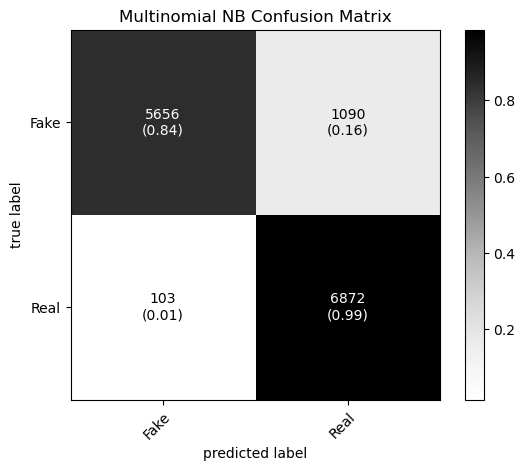

Multinomial NB accuracy:   69.997
Multinomial NB
               precision    recall  f1-score   support

        Fake       0.66      0.83      0.73      3107
        Real       0.77      0.57      0.66      3149

    accuracy                           0.70      6256
   macro avg       0.71      0.70      0.70      6256
weighted avg       0.72      0.70      0.70      6256



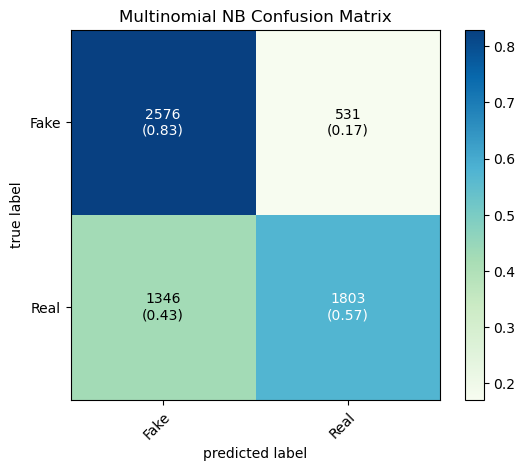

Multinomial NB accuracy:   92.935
Multinomial NB
               precision    recall  f1-score   support

        Fake       0.91      0.95      0.93      3107
        Real       0.95      0.91      0.93      3149

    accuracy                           0.93      6256
   macro avg       0.93      0.93      0.93      6256
weighted avg       0.93      0.93      0.93      6256



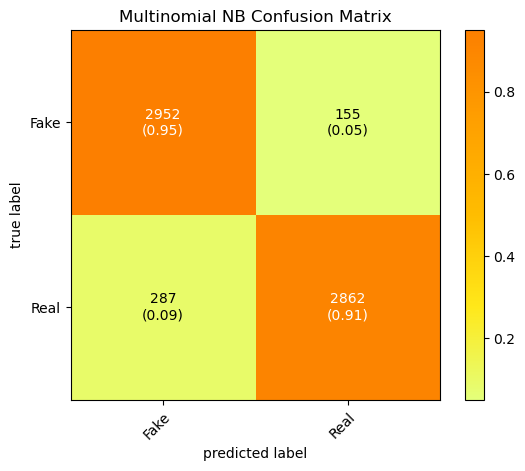

In [29]:
MNB_model = pickle.load(open('Multinomial_NB.sav', 'rb'))
test(MNB_model, "Multinomial NB", x_test, y_test, 'Greys')
test(MNB_model, "Multinomial NB", test_df['title'], test_df['label'], 'GnBu')
test(MNB_model, "Multinomial NB", test_df['text'], test_df['label'], 'Wistia')

### Support Vector Machine

SVM accuracy:   95.758
SVM
               precision    recall  f1-score   support

        Fake       0.96      0.95      0.96      6746
        Real       0.96      0.96      0.96      6975

    accuracy                           0.96     13721
   macro avg       0.96      0.96      0.96     13721
weighted avg       0.96      0.96      0.96     13721



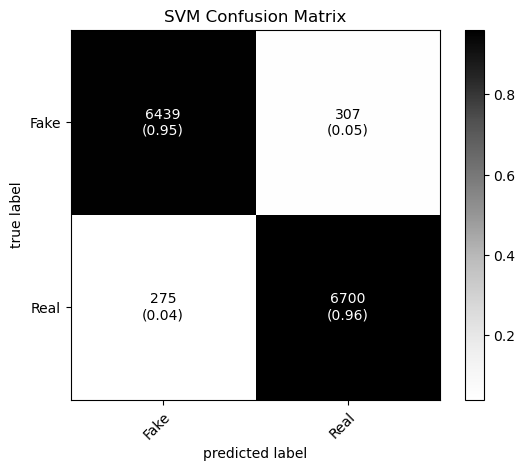

SVM accuracy:   53.245
SVM
               precision    recall  f1-score   support

        Fake       0.52      0.98      0.68      3107
        Real       0.84      0.09      0.16      3149

    accuracy                           0.53      6256
   macro avg       0.68      0.54      0.42      6256
weighted avg       0.68      0.53      0.42      6256



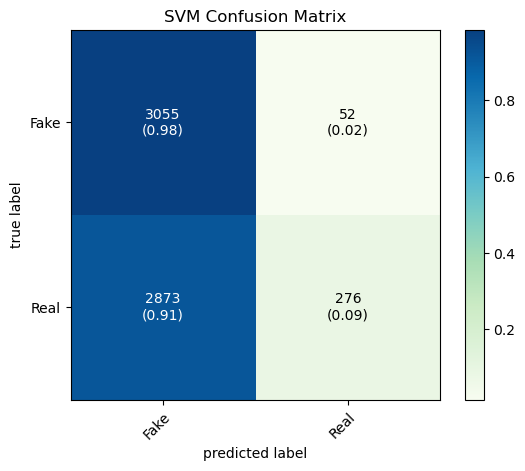

SVM accuracy:   95.668
SVM
               precision    recall  f1-score   support

        Fake       0.93      0.99      0.96      3107
        Real       0.99      0.92      0.96      3149

    accuracy                           0.96      6256
   macro avg       0.96      0.96      0.96      6256
weighted avg       0.96      0.96      0.96      6256



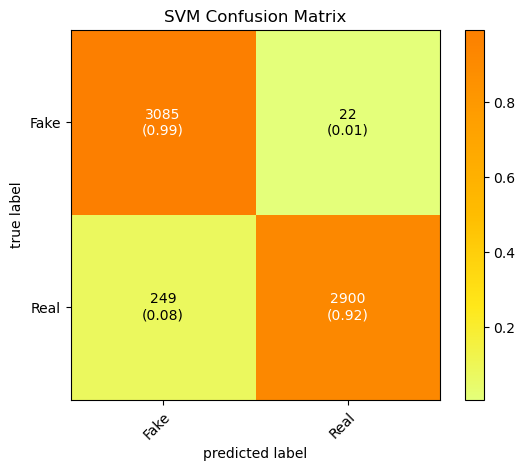

In [12]:
SVM_model = pickle.load(open('SVM.sav', 'rb'))
test(SVM_model, "SVM", x_test, y_test, 'Greys')
test(SVM_model, "SVM", test_df['title'], test_df['label'], 'GnBu')
test(SVM_model, "SVM", test_df['text'], test_df['label'], 'Wistia')

### Logistic Regression

Logistic Regression accuracy:   93.412
Logistic Regression
               precision    recall  f1-score   support

        Fake       0.93      0.93      0.93      6746
        Real       0.93      0.94      0.94      6975

    accuracy                           0.93     13721
   macro avg       0.93      0.93      0.93     13721
weighted avg       0.93      0.93      0.93     13721



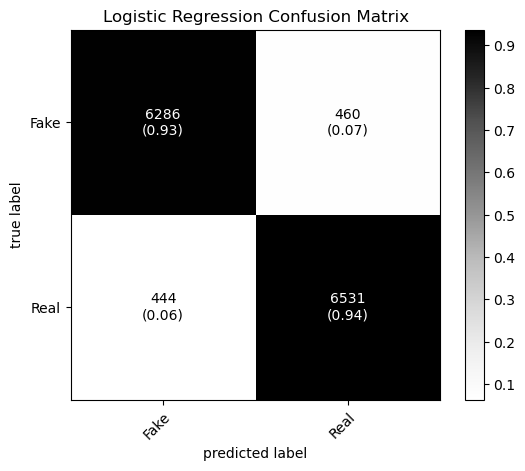

Logistic Regression accuracy:   53.117
Logistic Regression
               precision    recall  f1-score   support

        Fake       0.51      0.98      0.67      3107
        Real       0.81      0.09      0.16      3149

    accuracy                           0.53      6256
   macro avg       0.66      0.53      0.42      6256
weighted avg       0.66      0.53      0.42      6256



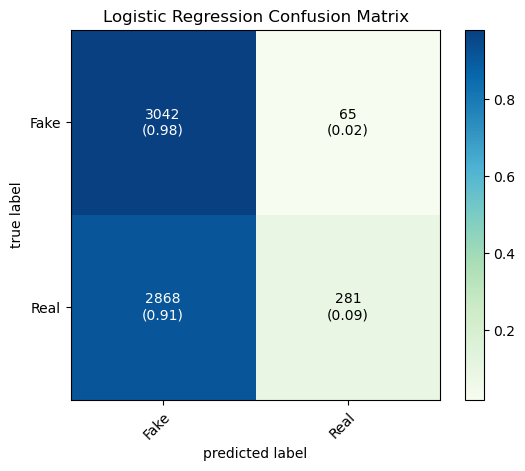

Logistic Regression accuracy:   86.765
Logistic Regression
               precision    recall  f1-score   support

        Fake       0.80      0.98      0.88      3107
        Real       0.97      0.76      0.85      3149

    accuracy                           0.87      6256
   macro avg       0.89      0.87      0.87      6256
weighted avg       0.89      0.87      0.87      6256



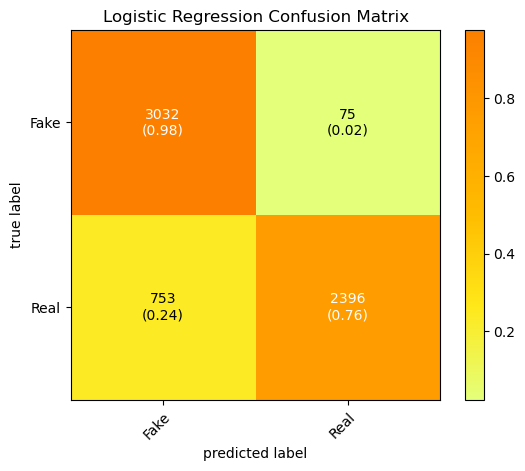

In [31]:
LR_model = pickle.load(open('Logistic_Regression.sav', 'rb'))
test(LR_model, "Logistic Regression", x_test, y_test, 'Greys')
test(LR_model, "Logistic Regression", test_df['title'], test_df['label'], 'GnBu')
test(LR_model, "Logistic Regression", test_df['text'], test_df['label'], 'Wistia')

### Passive Aggressive Classifier

Passive Aggressive Classifier accuracy:   96.028
Passive Aggressive Classifier
               precision    recall  f1-score   support

        Fake       0.97      0.95      0.96      6746
        Real       0.96      0.97      0.96      6975

    accuracy                           0.96     13721
   macro avg       0.96      0.96      0.96     13721
weighted avg       0.96      0.96      0.96     13721



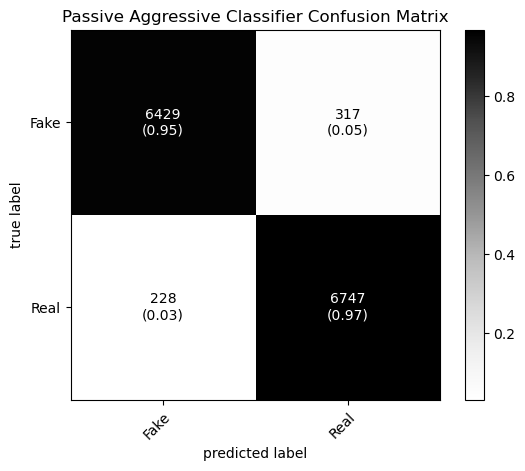

Passive Aggressive Classifier accuracy:   55.195
Passive Aggressive Classifier
               precision    recall  f1-score   support

        Fake       0.53      0.98      0.69      3107
        Real       0.87      0.13      0.22      3149

    accuracy                           0.55      6256
   macro avg       0.70      0.55      0.45      6256
weighted avg       0.70      0.55      0.45      6256



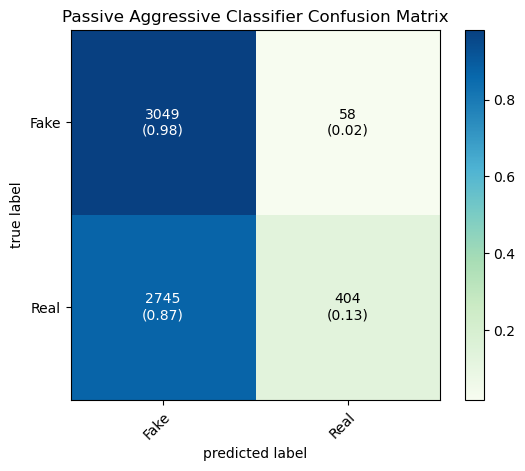

Passive Aggressive Classifier accuracy:   96.084
Passive Aggressive Classifier
               precision    recall  f1-score   support

        Fake       0.93      0.99      0.96      3107
        Real       0.99      0.93      0.96      3149

    accuracy                           0.96      6256
   macro avg       0.96      0.96      0.96      6256
weighted avg       0.96      0.96      0.96      6256



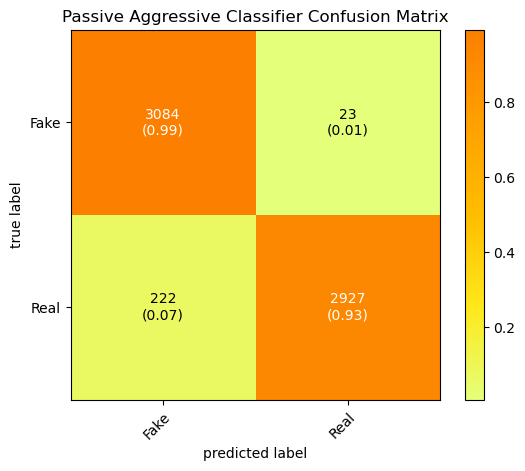

In [32]:
PAC_model = pickle.load(open('PAC.sav', 'rb'))
test(PAC_model, "Passive Aggressive Classifier", x_test, y_test, 'Greys')
test(PAC_model, "Passive Aggressive Classifier", test_df['title'], test_df['label'], 'GnBu')
test(PAC_model, "Passive Aggressive Classifier", test_df['text'], test_df['label'], 'Wistia')

### Random Forest

Random Forest accuracy:   93.186
Random Forest
               precision    recall  f1-score   support

        Fake       0.93      0.93      0.93      6746
        Real       0.93      0.93      0.93      6975

    accuracy                           0.93     13721
   macro avg       0.93      0.93      0.93     13721
weighted avg       0.93      0.93      0.93     13721



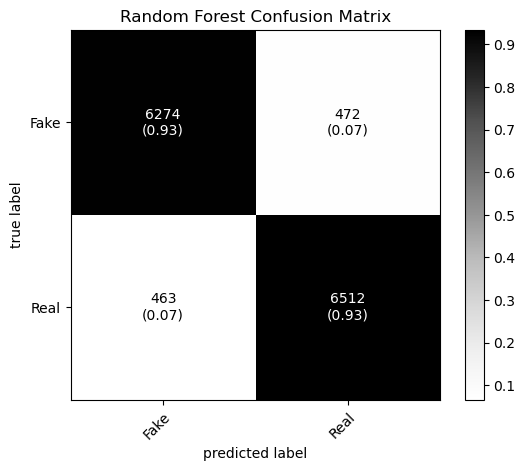

Random Forest accuracy:   49.760
Random Forest
               precision    recall  f1-score   support

        Fake       0.50      1.00      0.66      3107
        Real       0.67      0.00      0.01      3149

    accuracy                           0.50      6256
   macro avg       0.58      0.50      0.34      6256
weighted avg       0.58      0.50      0.33      6256



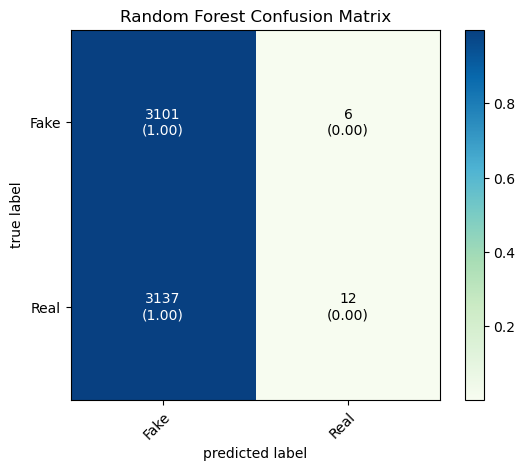

Random Forest accuracy:   92.919
Random Forest
               precision    recall  f1-score   support

        Fake       0.88      0.99      0.93      3107
        Real       0.98      0.87      0.93      3149

    accuracy                           0.93      6256
   macro avg       0.93      0.93      0.93      6256
weighted avg       0.93      0.93      0.93      6256



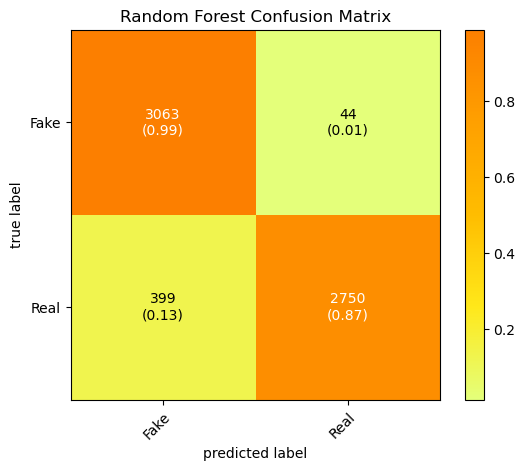

In [33]:
RF_model = pickle.load(open('Random_Forest.sav', 'rb'))
test(RF_model, "Random Forest", x_test, y_test, 'Greys')
test(RF_model, "Random Forest", test_df['title'], test_df['label'], 'GnBu')
test(RF_model, "Random Forest", test_df['text'], test_df['label'], 'Wistia')

### Extreme Gradient Boost

XGBoost accuracy:   91.670
XGBoost
               precision    recall  f1-score   support

        Fake       0.89      0.95      0.92      6746
        Real       0.94      0.89      0.92      6975

    accuracy                           0.92     13721
   macro avg       0.92      0.92      0.92     13721
weighted avg       0.92      0.92      0.92     13721



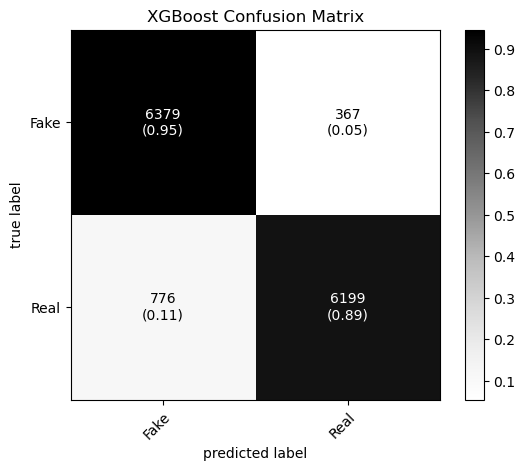

XGBoost accuracy:   49.888
XGBoost
               precision    recall  f1-score   support

        Fake       0.50      0.99      0.66      3107
        Real       0.63      0.01      0.02      3149

    accuracy                           0.50      6256
   macro avg       0.56      0.50      0.34      6256
weighted avg       0.56      0.50      0.34      6256



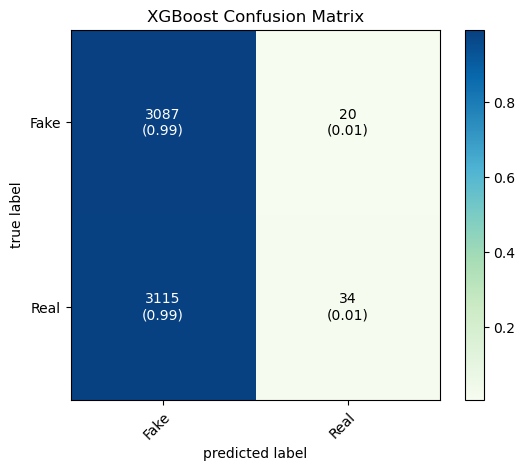

XGBoost accuracy:   77.206
XGBoost
               precision    recall  f1-score   support

        Fake       0.69      0.96      0.81      3107
        Real       0.94      0.58      0.72      3149

    accuracy                           0.77      6256
   macro avg       0.82      0.77      0.76      6256
weighted avg       0.82      0.77      0.76      6256



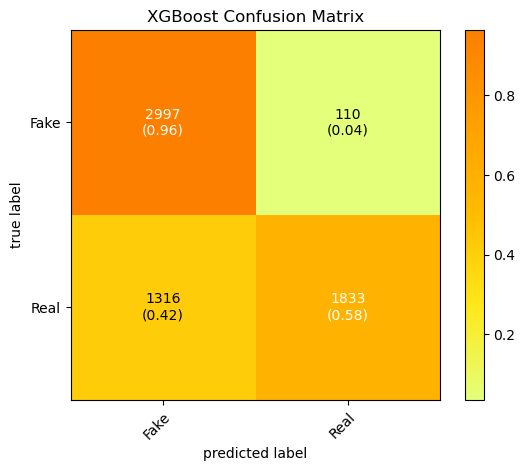

In [34]:
#load the XGB model
XGB_model = pickle.load(open('XG_Boost.sav', 'rb'))
test(XGB_model, "XGBoost", x_test, y_test, 'Greys')
test(XGB_model, "XGBoost", test_df['title'], test_df['label'], 'GnBu')
test(XGB_model, "XGBoost", test_df['text'], test_df['label'], 'Wistia')